In [113]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from openbb_terminal.sdk import openbb
from datetime import datetime, timedelta, date
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import stats, interpolate, optimize
from scipy.stats import norm 
import plotly.graph_objs as go

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
from RNDs_functions import * # 2 a little bit longer functions in separate file.

In [5]:
#The procedure of data aquisition from yahoo finance with OpenBB:
#chain_raw = openbb.stocks.options.load_options_chains("SPY",source='YahooFinance')
#date = datetime(2023, 10, 30, 10, 00)
#testing = wrangle_eod_chain_data(chain_raw, date, source= "yahoofinance")
#testing.head()

In [81]:
option_df = pd.read_csv("C:/Users/anton/Documents/data/Options_modeling/raw/SPY_clean_01112023yf.csv")
option_df.head()

,Unnamed: 0,Right,Expiration,Strike,Close,DTE,Maturity_days
0,0,call,2023-11-01 11:59:00,350.0,72.555,0.005479,2
1,1,call,2023-11-01 11:59:00,361.0,61.555,0.005479,2
2,2,call,2023-11-01 11:59:00,370.0,52.550,0.005479,2
3,3,call,2023-11-01 11:59:00,380.0,42.550,0.005479,2
4,4,call,2023-11-01 11:59:00,384.0,38.535,0.005479,2


In [82]:
option_df = option_df.drop(columns=['Unnamed: 0'])
option_df['Right'] = option_df['Right'].replace({'call': 'C', 'put': 'P'})

# Analyzing the expirations until 200 calendar days
option_df = option_df[option_df["Maturity_days"] < 200]

df_calls = option_df[option_df["Right"] == "C"]
df_puts = option_df[option_df["Right"] == "P"]

In [83]:
Spot = 422.66

In [84]:
higher_strike = 460
lower_strike = 410
df_calls_temp = df_calls[(df_calls["Strike"] > lower_strike) & (df_calls["Strike"] < higher_strike)]
#df_calls_temp = df_calls_temp[(df_calls_temp["Maturity_days"] > 10) & (df_calls_temp["Maturity_days"] < 60)]
plot_3D(df_calls_temp, unique_parameter = "Maturity_days",z_column = "Close")

### Interest rate interpolation
I will use cubic spline interpolation for itnerest rate. Probably the better choice would be Nelson-Siegel

In [85]:
def get_curve():
    """
    Parameters: None
    Function returns last US yields feom 1 to 120 months
    The dates are represented in days 
    """
    curve = openbb.economy.usbonds()
    curve["Yld (%)"] = pd.to_numeric(curve["Yld (%)"])
    curve = curve.rename(columns={"Yld (%)": "yield"})
    curve["yield"] = round(curve["yield"]/100, 6)
    curve = curve.iloc[1:,:]

    indices = [round(x,4) for x in [1, 3, 6, 12, 24, 36, 60, 84, 120]]
    curve = curve.set_index(pd.Index(indices[::-1]))
    curve = curve[["yield"]].sort_index()
    curve.index = curve.index*30

    return curve

def interpolate_US_rate():
    #curve = curve[curve.index <= 60]
    curve = get_curve()
    
    terms = curve.index 
    rates = curve['yield'].to_list()

    max_exp = max(terms)
    new_terms = [i for i in range(max_exp)]
    
    f = interpolate.CubicSpline(terms, rates)
    # interpolate the values based on the new terms we created above
    ff = f(new_terms)
    # return the interpolated rate given the days to expiration
    return ff

def assign_interest_rate(day, interpolated_series):
    """
    interpolated_series = interpolate_US_rate()
    How to use? --> df["rrrrr"] = df['Maturity_days'].apply(lambda day: interpolated_series[day])
    
    """
    return interpolated_series[day]

In [86]:
def interest_rate(df):
    interpolated_series = interpolate_US_rate()
    df["r"] = df['Maturity_days'].apply(lambda day: interpolated_series[day])
    return df

In [87]:
df_calls  = interest_rate(df_calls)
df_puts = interest_rate(df_puts)
option_df_with_r = interest_rate(option_df)

INFO:openbb_terminal.economy.wsj_model:START
INFO:openbb_terminal.economy.wsj_model:END
INFO:openbb_terminal.economy.wsj_model:START
INFO:openbb_terminal.economy.wsj_model:END
INFO:openbb_terminal.economy.wsj_model:START
INFO:openbb_terminal.economy.wsj_model:END


### Transformation of ITM puts/calls (illiquid) with OTM call/puts (liquid)

In [88]:
def ITM_valuation_by_parity(df, put_call_final, spot):

    unique_expirations = df["Expiration"].unique()
    #unique_expirations = unique_expirations[11:12]
    all_results = []

    for exp_uni in unique_expirations:
        # Search for ATM strikes
        df_exp = df[df["Expiration"] == exp_uni]

        strike_location = (df_exp["Strike"] - spot).abs().sort_values().index[0]
        ATM_strike = df_exp.loc[strike_location]["Strike"]

        df_puts = df_exp[df_exp["Right"] == "P"]
        df_calls = df_exp[df_exp["Right"] == "C"]
        liquid_calls = df_calls[(df_calls["Strike"] > ATM_strike)]
        illiquid_calls = df_calls[(df_calls["Strike"] < ATM_strike)]
        liquid_puts = df_puts[(df_puts["Strike"] <= ATM_strike)]
        illiquid_puts = df_puts[(df_puts["Strike"] > ATM_strike)]

        ir_uniq = df["r"].iloc[0]
        dte_uniq = df["DTE"].iloc[0]
        
        # ["Close"].iloc[0] is for taking the close value
        if not df_exp[(df_exp["Strike"] == ATM_strike) & (df_exp["Right"] == "P")].empty and not df_exp[(df_exp["Strike"] == ATM_strike) & (df_exp["Right"] == "C")].empty:
            put_implied = df_exp[(df_exp["Strike"] == ATM_strike) & (df_exp["Right"] == "P")]["Close"].iloc[0]
            call_implied = df_exp[(df_exp["Strike"] == ATM_strike) & (df_exp["Right"] == "C")]["Close"].iloc[0]

            implied_future = call_implied - put_implied + ATM_strike * np.exp(-ir_uniq * dte_uniq)
        else:
            print(f"No ATM strike for put/call at {exp_uni} expiration. Skipping...")
            continue

        implied_future = call_implied - put_implied + ATM_strike * np.exp(-ir_uniq*dte_uniq)

        #Now computing illiquid puts by liquid_calls
        if put_call_final == "put":
            liquid_calls["put_ITM_values"] = liquid_calls["Close"]  + liquid_calls["Strike"] * np.exp(-ir_uniq*dte_uniq) - implied_future

            liquid_calls["Close"] = liquid_calls["put_ITM_values"]
            liquid_calls.drop(columns = "put_ITM_values", inplace = True)
            liquid_calls["Right"] = "P"
            
            result_df = pd.concat([liquid_puts, liquid_calls], ignore_index=True)
            all_results.append(result_df)

        if put_call_final == "call":
            liquid_puts["call_ITM_values"] = liquid_puts["Close"]  - liquid_puts["Strike"] * np.exp(-ir_uniq*dte_uniq) + implied_future

            liquid_puts["Close"] = liquid_puts["call_ITM_values"]
            liquid_puts.drop(columns = "call_ITM_values", inplace = True)
            liquid_puts["Right"] = "C"
            
            result_df = pd.concat([liquid_puts, liquid_calls], ignore_index=True)
            all_results.append(result_df)

    final_result = pd.concat(all_results, ignore_index=True)

    return final_result

In [89]:
# Test for one expiration
df_parity = ITM_valuation_by_parity(option_df_with_r, put_call_final = "put", spot = Spot)
df_parity.tail()

No ATM strike for put/call at 2023-11-13 11:59:00 expiration. Skipping...


,Right,Expiration,Strike,Close,DTE,Maturity_days,r
2362,P,2024-03-28 11:59:00,555.0,126.231008,0.410959,150,0.05418
2363,P,2024-03-28 11:59:00,560.0,131.224531,0.410959,150,0.05418
2364,P,2024-03-28 11:59:00,565.0,136.223054,0.410959,150,0.05418
2365,P,2024-03-28 11:59:00,570.0,141.216577,0.410959,150,0.05418
2366,P,2024-03-28 11:59:00,575.0,146.215100,0.410959,150,0.05418


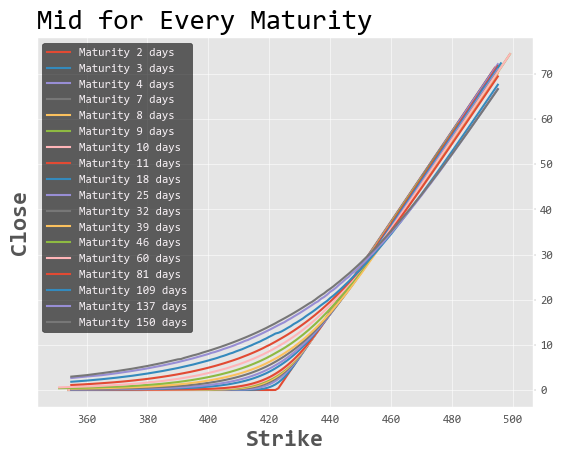

In [90]:
def plot_close_for_every_maturity(data):
    data = data[(data["Strike"] >350) & (data["Strike"] < 500)]
    grouped_data = data.groupby('Maturity_days')
    
    for name, group in grouped_data:
        plt.plot(group['Strike'], group['Close'], label=f'Maturity {name} days')

    plt.title('Mid for Every Maturity', fontsize = 20, color = "black")
    plt.xlabel('Strike', fontsize = 17)
    plt.ylabel('Close', fontsize = 17)
    plt.legend(loc = "best")
    plt.grid(True)
    plt.show()

plot_close_for_every_maturity(df_parity)

In [91]:
uni_exp = df_parity["Expiration"].unique()
def plot_hig_low_close_exp(df, expiration):
    df = df[(df["Strike"] > 400) & (df["Strike"] < 550)]
    x = df[df["Expiration"] == expiration]["Strike"]
    y = df[df["Expiration"] == expiration]['Close']


    df_exp = option_df_with_r[option_df_with_r["Expiration"] == expiration]
    df_exp = df_exp[df_exp["Right"] == "P"]
    strike_location = (df_exp["Strike"] - Spot).abs().sort_values().index[0]
    ATM_strike = df_exp.loc[strike_location]["Strike"]
    illiquid_puts = df_exp[(df_exp["Strike"] > ATM_strike)].sort_values(by = "Strike")
    x_illiq = illiquid_puts["Strike"]
    y_illiq = illiquid_puts["Close"]

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='', color='blue', label='Close form put-call parity')
    plt.plot(x_illiq, y_illiq, marker='^', color='red', linestyle='', label='Puts Close')
    plt.legend()

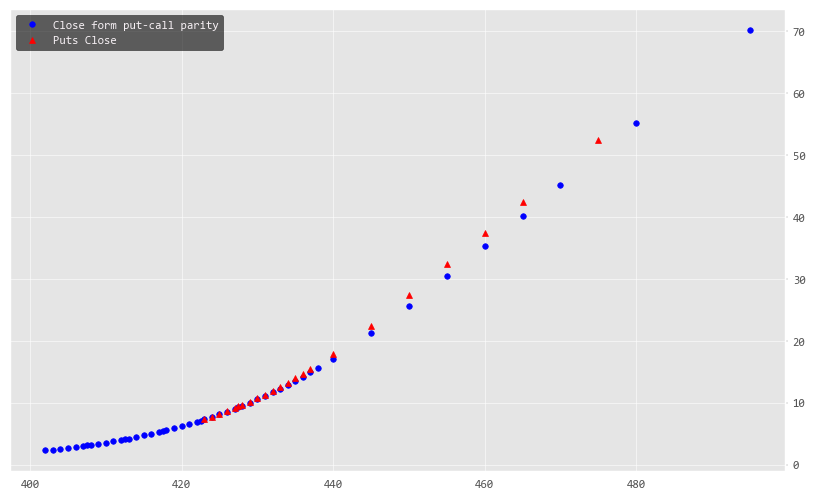

In [95]:
plot_hig_low_close_exp(df_parity, uni_exp[-7])

### IVs calculation

In [96]:
def BS_d1(S, K, r, q, sigma, tau):
    d1 = 1 * (np.log(1.0 * S/K) + (r - q + sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d1

def BS_d2(S, K, r, q, sigma, tau):
    d2 = 1.0*(np.log(1.0 * S/K) + (r - q - sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d2

def BS_price(type_option, S, K, r, q, sigma, T, t=0):
    tau = T - t
    d1 = BS_d1(S, K, r, q, sigma, tau)
    d2 = BS_d2(S, K, r, q, sigma, tau)
    if type_option == 'call':
        price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    elif type_option == 'put':
        price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1) 
    return price

def BS_ob_fun(sigma, P, type_option, S, K, r, q, T, t=0):
    BS_price_calculated = BS_price(type_option, S, K, r, q, sigma, T, t)
    price_difference = BS_price_calculated - P
    return price_difference

def imp_vol_calc_P(row, spot):
    S_0 = spot
    K = row['Strike']      
    r = row["r"]             
    q = 0.0                
    T_years = row['DTE']
    
    P_put = row['Close']   
    try:
        implied_volatility = optimize.brentq(BS_ob_fun, 0.0001, 2, args=(P_put, 'put', S_0, K, r, q, T_years))
        return np.nan if implied_volatility <= 1.0e-6 else implied_volatility
    except ValueError:
        implied_volatility = np.nan    
    
    return implied_volatility

def imp_vol_calc_C(row, spot):
    S_0 = spot
    K = row['Strike']      
    r = row["r"]             
    q = 0.0                
    T_years = row['DTE']
    
    P_call= row['Close']   
    try:
        implied_volatility = optimize.brentq(BS_ob_fun, 0.001, 2, args=(P_call, 'call', S_0, K, r, q, T_years))
        return np.nan if implied_volatility <= 1.0e-6 else implied_volatility
    except ValueError:
        implied_volatility = np.nan    
    
    return implied_volatility

In [97]:
df_parity["IV"] = df_parity.apply(imp_vol_calc_P, args=(Spot,), axis = 1)

In [98]:
#% of nan after IV computation
df_parity["IV"].isna().sum()/len(df_parity["IV"])

0.0

In [21]:
#Making masks for plotting
df_parity_mask = df_parity[(df_parity["Strike"] <= Spot + 100) & (df_parity["Strike"] >= Spot - 150)]

In [99]:
def plot_iv(df, start, end):
    expirations = df["Maturity_days"].unique()[start:end]
    iv_multi = df[df["Maturity_days"].isin(expirations)]
    iv_pivoted = (iv_multi[["Maturity_days", "Strike", "IV"]]
    .pivot(index="Strike", columns="Maturity_days", values="IV")
    .dropna())
    
    # Scatter plot
    for column in iv_pivoted.columns:
        plt.scatter(iv_pivoted.index, iv_pivoted[column], label=column)

    plt.xlabel('Strike')
    plt.ylabel('IV')
    plt.title('IV Scatter Plot')
    plt.legend()
    plt.show()

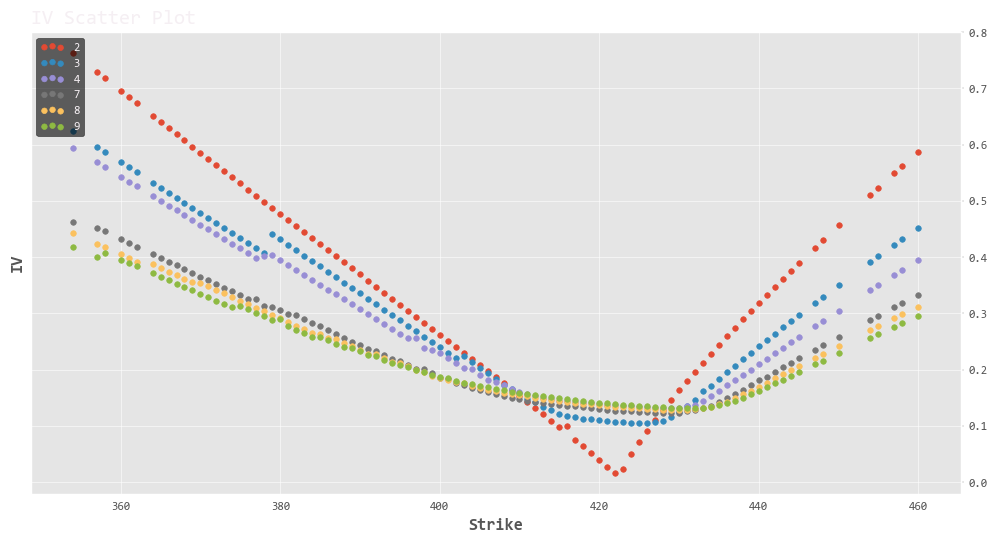

In [114]:
plot_iv(df_parity_mask, start = 0, end = 6)

#### As we can see, there are some jumps in IVs, which should not occur. We'll handle it shortly when doing interpolation and optional filtering

In [101]:
plot_3D(df_parity_mask, unique_parameter = "Maturity_days",z_column = "IV")

### IV interpolation

Let's see different types and choices for interpolation

In [104]:
def delete_low_counts(df, min_entries):
    entry_counts = df.groupby('Expiration').size()
    filtered_df = df[df["Expiration"].isin(entry_counts[entry_counts >= min_entries].index)]
    return filtered_df

In [105]:
df_parity_inerp = delete_low_counts(df_parity, min_entries=25)
df_parity_inerp["Expiration"].unique()

array(['2023-11-01 11:59:00', '2023-11-02 11:59:00',
       '2023-11-03 11:59:00', '2023-11-06 11:59:00',
       '2023-11-07 11:59:00', '2023-11-08 11:59:00',
       '2023-11-09 11:59:00', '2023-11-10 11:59:00',
       '2023-11-17 11:59:00', '2023-11-24 11:59:00',
       '2023-12-01 11:59:00', '2023-12-08 11:59:00',
       '2023-12-15 11:59:00', '2023-12-29 11:59:00',
       '2024-01-19 11:59:00', '2024-02-16 11:59:00',
       '2024-03-15 11:59:00', '2024-03-28 11:59:00'], dtype=object)

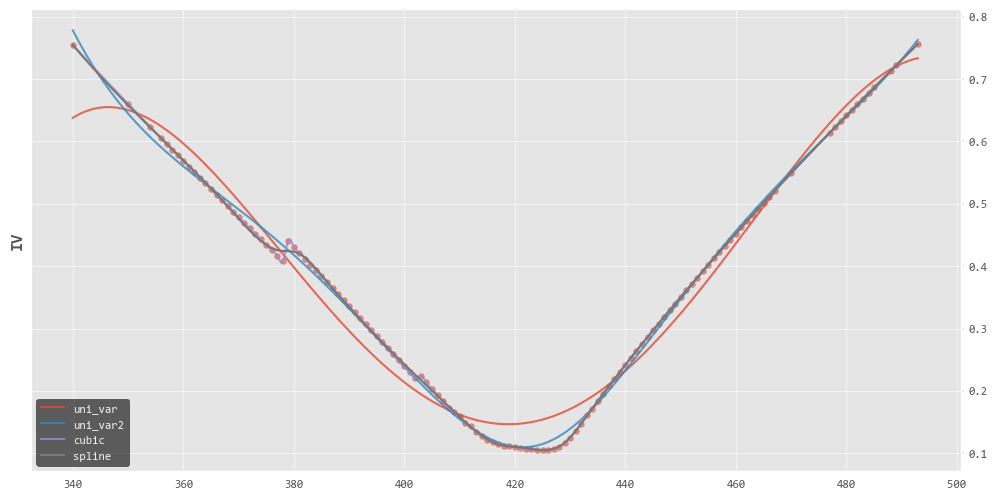

In [115]:
unique_expirations = df_parity_inerp["Expiration"].unique()
df_analysis = df_parity_inerp[df_parity_inerp["Expiration"] == unique_expirations[1]]
df_analysis = df_analysis.sort_values(by = "Strike")

uni_var = scipy.interpolate.UnivariateSpline(df_analysis["Strike"], df_analysis["IV"], s = 2, k = 4)
uni_var2 = scipy.interpolate.UnivariateSpline(df_analysis["Strike"], df_analysis["IV"], s=0.01, k=4)
cubic = scipy.interpolate.interp1d(df_analysis["Strike"], df_analysis["IV"], kind="cubic",fill_value="extrapolate")
spline = scipy.interpolate.UnivariateSpline(df_analysis["Strike"], df_analysis["IV"], s=0.001, k=3) 

x_new = np.arange(df_analysis["Strike"].min(), df_analysis["Strike"].max(), 0.1)

plt.scatter(df_analysis["Strike"], df_analysis["IV"], alpha = 0.6);

plt.plot(x_new, uni_var(x_new), alpha = 0.8, label = "uni_var");
plt.plot(x_new, uni_var2(x_new), alpha = 0.8, label = "uni_var2");
plt.plot(x_new, cubic(x_new), alpha = 0.8, label = "cubic");
plt.plot(x_new, spline(x_new), label = "spline");

plt.legend(loc="best")
plt.ylabel("IV")
plt.show();

In [116]:
def all_exp_to_prices(df):
    unique_exp = df["Expiration"].unique()
    filtered_dfs = []
    for exp in unique_exp:
        df_exp = df[df["Expiration"] == exp]
        df_exp = df_exp.sort_values(by = "Strike")

        x_new = np.arange(df_exp["Strike"].min(), df_exp["Strike"].max(), 0.1)
        spline = scipy.interpolate.UnivariateSpline(df_exp["Strike"], df_exp["IV"], s = 0.01, k = 4)
        ivs_for_new_prices = spline(x_new)


        interest_rate = (df_exp["r"].unique())[0]
        DTE_ = (df_exp["DTE"].unique())[0]
        Spot_ = Spot
        option_type = "put"

        put_data_list = []

        for i in range(len(x_new)):

            strike = x_new[i]
            implied_volatility = ivs_for_new_prices[i]
            put_price = BS_price(option_type, S=Spot_, K=strike, T=DTE_, r=interest_rate, sigma=implied_volatility, q = 0)
            
            put_data = {
                'Expiration': exp,
                'Strike': strike,
                'Right': "P",
                'Close': put_price,
                "IV": implied_volatility,
                "DTE": DTE_,
                "r": interest_rate
            }
            put_data_list.append(put_data)

        filtered_dfs.append(pd.DataFrame(put_data_list))
    
    result_df = pd.concat(filtered_dfs, ignore_index=True)
    
    return result_df

In [117]:
df_interpolated = all_exp_to_prices(df_parity_inerp)
df_interpolated

,Expiration,Strike,Right,Close,IV,DTE,r
0,2023-11-01 11:59:00,340.0,P,0.005822,0.934377,0.005479,0.053918
1,2023-11-01 11:59:00,340.1,P,0.005798,0.932892,0.005479,0.053918
2,2023-11-01 11:59:00,340.2,P,0.005774,0.931410,0.005479,0.053918
3,2023-11-01 11:59:00,340.3,P,0.005750,0.929933,0.005479,0.053918
4,2023-11-01 11:59:00,340.4,P,0.005726,0.928460,0.005479,0.053918
...,...,...,...,...,...,...,...
48225,2024-03-28 11:59:00,574.5,P,146.568036,0.384960,0.410959,0.054180
48226,2024-03-28 11:59:00,574.6,P,146.673865,0.385241,0.410959,0.054180
48227,2024-03-28 11:59:00,574.7,P,146.779703,0.385522,0.410959,0.054180
48228,2024-03-28 11:59:00,574.8,P,146.885551,0.385804,0.410959,0.054180


In [49]:
df_to_rnd = df_interpolated[(df_interpolated["Strike"] > 290) & (df_interpolated["Strike"] < 550)]
df_to_rnd = df_to_rnd[df_to_rnd["DTE"] > 0.03]

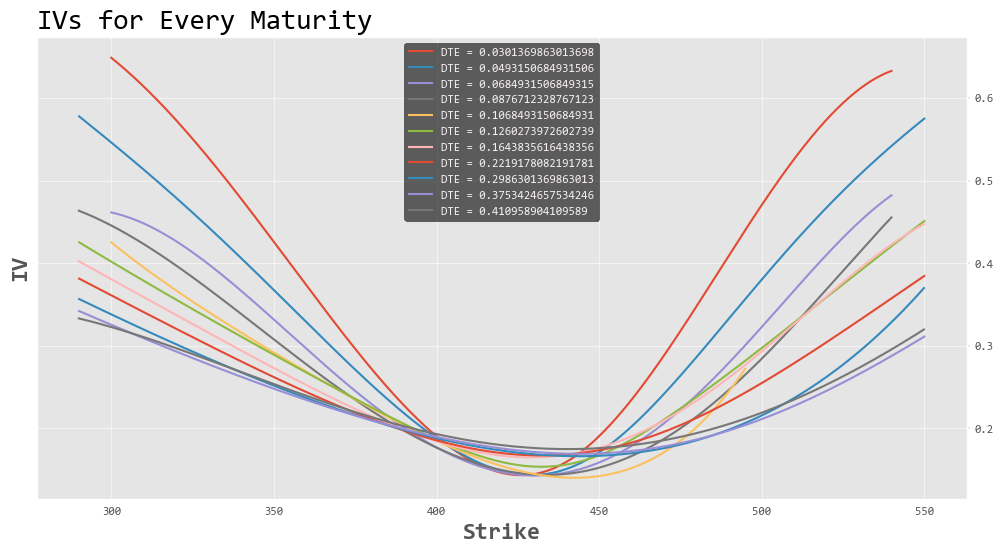

In [118]:
def plot_close_for_every_maturity(data):
    grouped_data = data.groupby('DTE')
    
    for name, group in grouped_data:
        plt.plot(group['Strike'], group['IV'], label=f'DTE = {name}')

    plt.title('IVs for Every Maturity', fontsize = 20, color = "black")
    plt.xlabel('Strike', fontsize = 17)
    plt.ylabel('IV', fontsize = 17)
    plt.legend(loc = "best")
    plt.grid(True)
    plt.show()

plot_close_for_every_maturity(df_to_rnd)

### RNDs - ccreating single/multiple rnds

In [119]:
def create_rnd(df):
    df = df.sort_values(by = "Strike")
    prices = df["Close"]
    strikes = df["Strike"]
    dte = df["DTE"]
    r = df["r"]

    first_grad = np.gradient(prices, strikes)
    second_grad = np.gradient(first_grad, strikes)

    return strikes, second_grad * np.exp(dte * r)

In [120]:
def create_rnd_multiple(df):
    unique_exp = df["Expiration"].unique()
    result_dfs = []

    for exp in unique_exp:
        df_exp = df[df["Expiration"] == exp]
        rnd_strikes, rnd_values = create_rnd(df_exp)

        result_df = pd.DataFrame({"Strike": rnd_strikes, "RND": rnd_values})
        result_df["Expiration"] = exp  # Add the expiration date as a column
        result_dfs.append(result_df)
    
    
    result_df = pd.concat(result_dfs, ignore_index=True)
    
    return result_df

In [121]:
rnd_df = create_rnd_multiple(df_to_rnd)
rnd_df

,Strike,RND,Expiration
0,300.0,0.000007,2023-11-10 11:59:00
1,300.1,0.000010,2023-11-10 11:59:00
2,300.2,0.000014,2023-11-10 11:59:00
3,300.3,0.000014,2023-11-10 11:59:00
4,300.4,0.000014,2023-11-10 11:59:00
...,...,...,...
27444,549.5,0.001264,2024-03-28 11:59:00
27445,549.6,0.001263,2024-03-28 11:59:00
27446,549.7,0.001262,2024-03-28 11:59:00
27447,549.8,0.000946,2024-03-28 11:59:00


In [122]:
def plot_rnds(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    uniques_exp = df["Expiration"].unique()

    for exp in uniques_exp:
        rnd_data = df[df["Expiration"] == exp]
        rnd_data = rnd_data.sort_values(by = "Strike")

        mask = rnd_data["RND"] >= 0

        filtered_strikes = rnd_data["Strike"][mask]
        filtered_grad_rnd = rnd_data["RND"][mask]

        label = exp.strftime("%Y-%m-%d")

        ax.plot(filtered_strikes, filtered_grad_rnd, label=label)
    ax.set_xlabel("Strike", color = "black")
    ax.set_ylabel("RNDs", color = "black")
    ax.set_title("RND Data by Expiration", color = "black")
    ax.legend()
    plt.show()

In [123]:
def plot_rnds_with_labels(df):
    unique_expirations = df["Expiration"].unique()
    fig, ax = plt.subplots(figsize=(10, 6))

    for expiration in unique_expirations:
        subset = df[df["Expiration"] == expiration]
        label = expiration.strftime("%Y-%m-%d")
        ax.plot(subset["Strike"], subset["RND"], label=label)

    ax.set_xlabel("Strike", color = "black")
    ax.set_ylabel("RNDs", color = "black")
    ax.set_title("RND Data by Expiration", color = "black")
    ax.legend()
    plt.show()

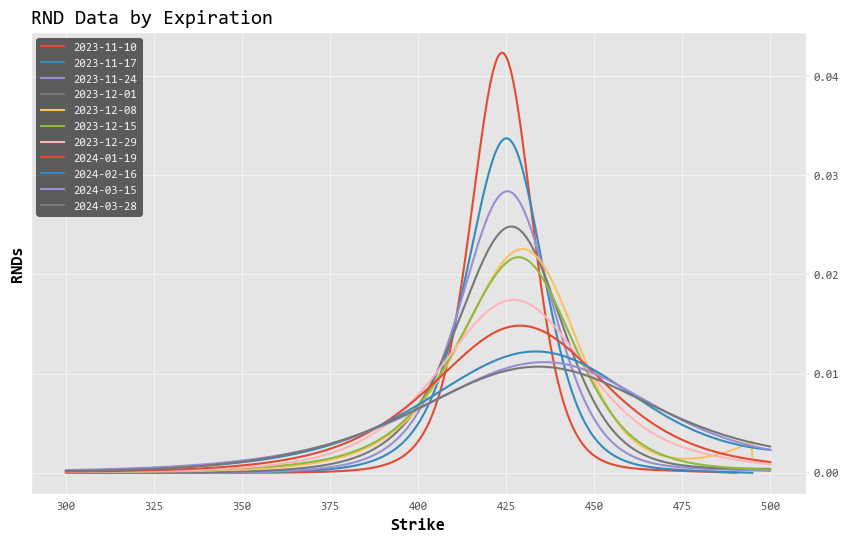

In [125]:
rnd_df["Expiration"] = pd.to_datetime(rnd_df["Expiration"])
mask_df = rnd_df[rnd_df["Expiration"] < datetime(2024,4,22)]
mask_df = mask_df[(mask_df["Strike"] > 300) & (mask_df["Strike"] < 500)]
#exclusion_dates = ['2023-12-08 11:59:00', '2024-02-16 11:59:00', '2023-11-09 11:59:00']
#mask_df = mask_df[~mask_df['Expiration'].isin(exclusion_dates)]
plot_rnds(mask_df)

In [126]:
def area_under_rnds(df):
    unique_exp = df["Expiration"].unique()
    result_data = []

    for expiration in unique_exp:
        df_exp = df[df["Expiration"] == expiration]
        interval_width = df_exp['Strike'].diff().fillna(0)
        area_under_curve = round((df_exp['RND'] * interval_width).sum(), 2)

        result_data.append({"Expiration": expiration, "Area_Under_Curve": area_under_curve})

    result_df = pd.DataFrame(result_data)
    return result_df

result_df = area_under_rnds(rnd_df)
result_df

,Expiration,Area_Under_Curve
0,2023-11-10 11:59:00,0.99
1,2023-11-17 11:59:00,1.00
2,2023-11-24 11:59:00,1.00
3,2023-12-01 11:59:00,1.01
4,2023-12-08 11:59:00,1.04
5,2023-12-15 11:59:00,1.01
6,2023-12-29 11:59:00,0.99
7,2024-01-19 11:59:00,1.02
8,2024-02-16 11:59:00,1.12
9,2024-03-15 11:59:00,1.03
